#Sammanfattning
I detta projekt så ska vi användas oss utav Reinforcement Learning. Reinforcement Learning är ett ganska brett område men i kort så går det ut på att träna agenter att fatta beslut och agera utefter vad som ger högst ackumelerad belöning. Vad som ger högst ackumelerad belöning lär sig nätverket så småningom med hjälp av träning. Dvs. agenten lär sig av erfarenhet. På detta vis kan man säga att Reinforcement Learning skiljer sig gentemot Supervised Learning, där modellen får träna med hjälp av rätta svar som ges till systemet. Detta förklarar också varför vi behöver ha med en del utforskning när vi bygger vår RL-modell eftersom att det är utforskningen som leder till att vår modell får erfarenhet och lär sig fatta beslut om optimala handlingar. I det här projektet ska vi använda oss av något som kallas Q-learning. Q-learning bygger på något som kallas Q-värden där ett q-värde(Q) motsvarar en uppskattning av hur bra en handling(A) är vid ett givet tillstånd(S). Dessa q-värden uppdateras allteftersom i takt med agenten tränas och får fler erfarenheter. T.ex kan det vara så att en aktion vid ett givet tillstånd ger väldigt lite ackumelerad belöning vid ett träningstillfälle då agenten går bort sig och förlorar i nästa eller nästnästa steg. Detta kan antingen bero på att den första handlingen var fel, men det kan också vara så att de följande handlingarna var de som var avgörande och att den första handlingen därför kan ha getts ett oförtjänt lågt Q-värde. Med hjälp av träning och utforskning kan agenten få möjligt att göra om det första steget och sedan göra på nya sätt. Skulle detta nu gå bättre så kommer Q-värdet för den första aktionen att justeras.

#Vad är Reinforcement Learning?


In [ ]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019
#Importerar nödvändiga bibliotek
import random
import gym
import matplotlib.pyplot as plt
from numpy import mean

#Definerar antalet försök - Ökar antalet episoder i ett försök att förbättre koden
EPISODES = 5000

"""Epsilon definerar med hur stor sannolikhet som agent är beredd att pröva någonting annat än den handling som ger högst Q-värde.
Dvs. ett lågt Epsilon kan bidra till att agenten stagnerar i ett lokalt maximum. 
Vi prövar med att sätta Epsilon till 0.2 för att minska stagnationen."""
EPSILON = 0.2

"""Definerar hur mycket credit en aktion ska få för framtida rewards,
ett värde nära 0 innebär att aktionen inte får mycket credit alls för framtida belöningar 
och ett värde nära 1 innebär att en aktion får nästan lika mycket belöning från framtida belöningar
som från direkt belöning. Vanligt är att ha en discount factor mellan 0,9 och 0,99. 
Med en discount på 0,95 så kommer kommer belöningar 13 steg(aktioner) ha halva värdet av en direkt belöning.
Detta ämnar att lösa "The Credit Assignment Problem" genom att visa på att det är flera steg än just
bara det allra senaste som bidrar till det slutgiltiga resultatet. 
Min egna slutsats efter att ha kört agenten ett antal gånger är att en aningen kortsiktigare agenten tycks höja den genomsnittliga prestationen."""
GAMMA = 0.88

#Learning rate definerar hur drastiskt agenten är beredd att ändra och justera sina q-values
LEARNING_RATE = 0.02
DISCRETE_STEPS = 10     # 10 discretization steps per state variable

def argmax(l):
    """ Return the index of the maximum element of a list
    """
    return max(enumerate(l), key=lambda x:x[1])[0]

def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41, -10.]
    high = [4.8, 10., 0.41, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete)
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete

    return state


Action space is: Discrete(2)
Observation space is: Box(4,)
0,12.0
100,9.0
200,10.0
300,41.0
400,9.0
500,10.0
600,9.0
700,33.0
800,8.0
900,11.0
1000,10.0
1100,17.0
1200,9.0
1300,11.0
1400,8.0
1500,13.0
1600,12.0
1700,26.0
1800,10.0
1900,9.0
2000,11.0
2100,14.0
2200,10.0
2300,11.0
2400,164.0
2500,35.0
2600,178.0
2700,143.0
2800,42.0
2900,42.0
3000,92.0
3100,13.0
3200,186.0
3300,174.0
3400,140.0
3500,151.0
3600,12.0
3700,169.0
3800,14.0
3900,37.0
4000,11.0
4100,153.0
4200,40.0
4300,13.0
4400,151.0
4500,22.0
4600,25.0
4700,10.0
4800,32.0
4900,198.0
highest cumulated reward:  4848
average cumulated reward:  47.4408


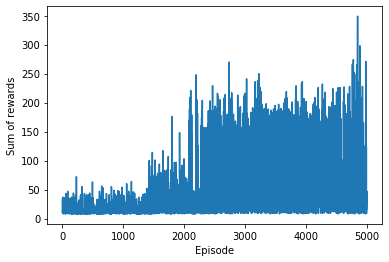

In [ ]:
def main():
    average_cumulative_reward = 0.0

    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    #Gör en array med belöningar för alla episoder
    rewards = []

    # Loop over episodes
    for i in range(EPISODES):
      #Återställer miljön
        state = env.reset()
        state = make_state(state)

        terminate = False

        #nollsätter den ackumulerade belöningen
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            #Greedy action är den aktion som uppskattas ges högst belöning
            qvalues = qtable[state]
            #greedy_action hämtas genom att ta argmax på alla q-vvärden
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment (självförklarande)
            if random.random() < EPSILON:
                action = random.randrange(2)
            else:
                action = greedy_action

            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
            # Show the simulated environment. A bit difficult to make it work.            
            #env.render()
            #print(' Reward:',reward)
            # Update the Q-Table
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LEARNING_RATE * td_error
            # Update statistics
            cumulative_reward += reward
            state = next_state
        rewards.append(cumulative_reward)
        
        # Per-episode statistics
        if ((i % 100)==0):
          print(i, cumulative_reward, sep=',')
    
    #Skriver ut den högst belöningen samt en graf på hur agenten presterat under de olika episoderna
    print("highest cumulated reward: ", argmax(rewards))
    print("average cumulated reward: ", mean(rewards))   
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Sum of rewards")
    plt.show()

#if __name__ == '__main__':
main()

